In [3]:
#!pip3 install Pillow

In [4]:
from __future__ import print_function, division
from torchsummary import summary
import os, torch, torchvision, PIL
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm 
import torch.nn as nn 

## Helper Functions

In [5]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()
    
def calculate_mu_std(path):
    files = os.listdir(path)
    if ".DS_Store" in files:
        files.remove(".DS_Store")

    if "grayscale" in path:
        rgb_values = np.concatenate( [Image.open(path+img).convert('L').getdata() for img in files], axis=0) / 255.
    # Calculating mean and std for normalization
    else:
        rgb_values = np.concatenate( [Image.open(path+img).getdata() for img in files], axis=0) / 255.

    # rgb_values.shape == (n, 3), 
    # where n is the total number of pixels in all images, 
    # and 3 are the 3 channels: R, G, B.

    # Each value is in the interval [0; 1]

    mu_rgb = np.mean(rgb_values, axis=0)  # mu_rgb.shape == (3,)
    std_rgb = np.std(rgb_values, axis=0)  # std_rgb.shape == (3,)
    return mu_rgb, std_rgb

gray_mu_std = calculate_mu_std("Data/grayscale/train/")
color_mu_std = calculate_mu_std("Data/color/train/")

## Creating Dataset

In [9]:
normalize_gray_transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = gray_mu_std[0],
                                        std = gray_mu_std[1])])

normalize_color_transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = color_mu_std[0],
                                        std = color_mu_std[1])])

# Preparing dataset class
class SneakersDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, normalizer = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_csv = pd.read_csv(csv_file)
        self.img_dir = root_dir
        self.normalizer = normalizer

        
        #Define dataset
        self.dataset_dir = os.path.join(os.getcwd(), root_dir)
        self.all_filenames = os.listdir(root_dir)
        self.all_labels = pd.read_csv(csv_file, header=0, index_col=0)
        self.label_meanings = self.all_labels.columns.values.tolist()
        
        
    def __len__(self):
        return len(self.data_csv)-1

    def __getitem__(self, idx): 
        #all normalization and data augmentation steps should be applied to the image before this method returns it.
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()
        '''
        
        file = self.data_csv.iloc[idx, 0]

        if "grayscale" in self.dataset_dir:
            imagepil = Image.open(os.path.join(self.img_dir, file)).convert('L')
        else:
            imagepil = Image.open(os.path.join(self.img_dir, file)).convert('RGB')
        
        #convert image to Tensor and normalize
        if self.normalizer != None:
            transform = self.normalizer
        else:
            transform = torchvision.transforms.ToTensor()
        image = transform(imagepil)

        label = torch.Tensor(self.all_labels.loc[file,:].values)
        sample = {'data':image, #preprocessed image, for input into NN
                  'label':label,
                  'img_idx':idx}
        
        return sample

# Getting datasets
gray_train_dataset = SneakersDataset(csv_file='train.csv', root_dir='Data/grayscale/train/', normalizer = normalize_gray_transform)
gray_test_dataset = SneakersDataset(csv_file='test.csv', root_dir='Data/grayscale/test/')
color_train_dataset = SneakersDataset(csv_file='train.csv', root_dir='Data/color/train/', normalizer = normalize_color_transform)
color_test_dataset =SneakersDataset(csv_file='test.csv', root_dir='Data/color/test/')

# Getting loaders from datasets
gray_train_loader = torch.utils.data.DataLoader(gray_train_dataset, batch_size = 40, shuffle=True)
gray_test_loader = torch.utils.data.DataLoader(gray_test_dataset, batch_size = 40)
color_train_loader = torch.utils.data.DataLoader(color_train_dataset, batch_size = 40, shuffle=True)
color_test_loader = torch.utils.data.DataLoader(color_test_dataset, batch_size = 40)
classes = ('Jordan 1', 'Jordan 2', 'Jordan 3', 'Jordan 4', 'Jordan 5')

## Creating the model

In [24]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = nn.Conv2d(3, 6, 5)    
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(6, 7, 3)    
    self.relu2 = nn.ReLU() 
    self.cnn3 = nn.Conv2d(7, 8, 5)    
    self.relu3= nn.ReLU()
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(8*90*62, 5*8)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(8*5, 84)
    self.relu5 = nn.ReLU()
    self.fc3 = nn.Linear(84, 5)
    self.visualize = True

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    first = self.relu1(self.cnn1(x))
    out = self.relu2(self.cnn2(first))
        
    '''
    if self.visualize:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.visualize = False
    '''
    third = self.relu3(self.cnn3(out))
    fourth = self.relu4(self.fc1(torch.flatten(third, 1)))
    fifth = self.relu5(self.fc2(fourth))
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    return self.fc3(fifth)

# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 10**-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100

## Training and testing the model

In [25]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, info in enumerate(color_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for info in color_test_loader:
                images, labels = info["data"], info["label"]
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value

                predicted = torch.argmax(outputs,1)
                true_labels = torch.argmax(labels, 1)
                # Total number of labels
                total += len(true_labels)
                
                correct += (predicted == true_labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  4%|███▎                                                                              | 4/100 [00:17<07:08,  4.47s/it]

Iteration: 200  Loss: 0.4723767638206482  Accuracy: 37.3831787109375 %


  9%|███████▍                                                                          | 9/100 [00:39<06:31,  4.30s/it]

Iteration: 400  Loss: 0.004531380254775286  Accuracy: 40.72096252441406 %


 13%|██████████▌                                                                      | 13/100 [00:57<06:32,  4.52s/it]

Iteration: 600  Loss: 0.00039005628786981106  Accuracy: 42.323097229003906 %


 18%|██████████████▌                                                                  | 18/100 [01:19<05:59,  4.38s/it]

Iteration: 800  Loss: 0.0002023158158408478  Accuracy: 42.323097229003906 %


 22%|█████████████████▊                                                               | 22/100 [01:37<05:41,  4.37s/it]

Iteration: 1000  Loss: 0.0005405388656072319  Accuracy: 42.99065399169922 %


 27%|█████████████████████▊                                                           | 27/100 [01:58<05:07,  4.21s/it]

Iteration: 1200  Loss: 0.00010250873310724273  Accuracy: 43.92523193359375 %


 31%|█████████████████████████                                                        | 31/100 [02:15<04:58,  4.32s/it]

Iteration: 1400  Loss: 0.0001833623682614416  Accuracy: 44.325767517089844 %


 36%|█████████████████████████████▏                                                   | 36/100 [02:36<04:31,  4.24s/it]

Iteration: 1600  Loss: 8.715992589714006e-05  Accuracy: 44.058746337890625 %


 40%|████████████████████████████████▍                                                | 40/100 [02:54<04:19,  4.33s/it]

Iteration: 1800  Loss: 0.00016355350089725107  Accuracy: 44.192256927490234 %


 45%|████████████████████████████████████▍                                            | 45/100 [03:15<03:58,  4.33s/it]

Iteration: 2000  Loss: 5.7648187066661194e-05  Accuracy: 44.192256927490234 %


 50%|████████████████████████████████████████▌                                        | 50/100 [03:37<03:38,  4.37s/it]

Iteration: 2200  Loss: 2.243477683805395e-05  Accuracy: 43.52470016479492 %


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:54<03:17,  4.29s/it]

Iteration: 2400  Loss: 0.0025595971383154392  Accuracy: 43.12416458129883 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:15<02:49,  4.14s/it]

Iteration: 2600  Loss: 0.003532098140567541  Accuracy: 44.59278869628906 %


 63%|███████████████████████████████████████████████████                              | 63/100 [04:32<02:40,  4.33s/it]

Iteration: 2800  Loss: 0.00013904893421567976  Accuracy: 41.92256164550781 %


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:54<02:15,  4.23s/it]

Iteration: 3000  Loss: 6.458881398430094e-05  Accuracy: 42.85714340209961 %


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:11<02:01,  4.34s/it]

Iteration: 3200  Loss: 3.993184145656414e-05  Accuracy: 43.39118957519531 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:32<01:36,  4.20s/it]

Iteration: 3400  Loss: 7.267655018949881e-05  Accuracy: 44.325767517089844 %


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:50<01:22,  4.33s/it]

Iteration: 3600  Loss: 1.3844537534168921e-05  Accuracy: 44.325767517089844 %


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:11<00:59,  4.24s/it]

Iteration: 3800  Loss: 3.883691897499375e-05  Accuracy: 44.85981369018555 %


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:28<00:43,  4.35s/it]

Iteration: 4000  Loss: 3.505941276671365e-05  Accuracy: 43.92523193359375 %


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:49<00:21,  4.30s/it]

Iteration: 4200  Loss: 0.00010889924305956811  Accuracy: 44.325767517089844 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:11<00:00,  4.32s/it]

Iteration: 4400  Loss: 7.409546378767118e-05  Accuracy: 44.59278869628906 %


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 96, 68]             456
              ReLU-2            [-1, 6, 96, 68]               0
            Conv2d-3            [-1, 7, 94, 66]             385
              ReLU-4            [-1, 7, 94, 66]               0
            Conv2d-5            [-1, 8, 90, 62]           1,408
              ReLU-6            [-1, 8, 90, 62]               0
            Linear-7                   [-1, 40]       1,785,640
              ReLU-8                   [-1, 40]               0
            Linear-9                   [-1, 84]           3,444
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 5]             425
Total params: 1,791,758
Trainable params: 1,791,758
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forw

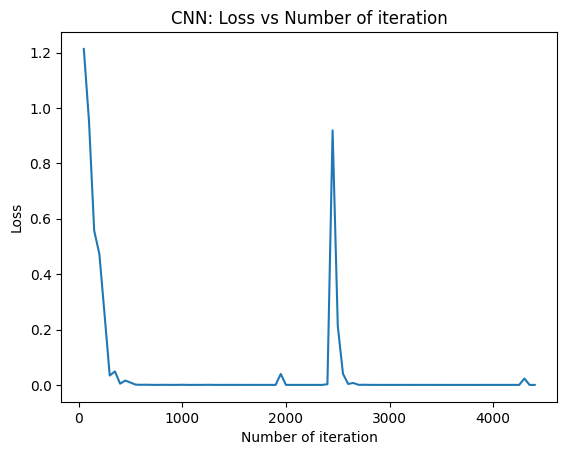

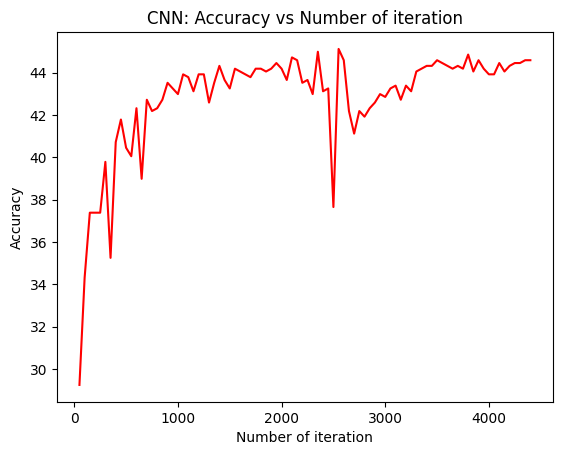

In [26]:
print(summary(model, (3, 100, 72)))

# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

## Creating Gray Model

In [ ]:
class CNNGrayModel(nn.Module):
  def __init__(self):
    super(CNNGrayModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = nn.Conv2d(1, 2, 5)    
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(2, 3, 3)    
    self.relu2 = nn.ReLU() 
    self.cnn3 = nn.Conv2d(3, 5, 5)    
    self.relu3= nn.ReLU()
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(5*90*62, 5*5)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(5*5, 84)
    self.relu5 = nn.ReLU()
    self.fc3 = nn.Linear(84, 5)
    self.visualize = True

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    first = self.relu1(self.cnn1(x))
    out = self.relu2(self.cnn2(first))
        
    '''
    if self.visualize:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.visualize = False
    '''
    third = self.relu3(self.cnn3(out))
    fourth = self.relu4(self.fc1(torch.flatten(third, 1)))
    fifth = self.relu5(self.fc2(fourth))
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    return self.fc3(fifth)

# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNGrayModel()
gray_model.to(device)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 10**-3
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)
num_epochs = 100

## Training and Testing

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            gray_model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for info in gray_test_loader:
                images, labels = info["data"], info["label"]
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = gray_model(images)
                
                # Get predictions from the maximum value

                predicted = torch.argmax(outputs,1)
                true_labels = torch.argmax(labels, 1)
                # Total number of labels
                total += len(true_labels)
                
                correct += (predicted == true_labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [ ]:
print(summary(gray_model, (1, 100, 72)))

# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()